In [108]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
ctwdf = 'CTWD_ProcessData.xlsx'
cvf = 'CV_ProcessData.xlsx'

ctwd = pd.read_excel(ctwdf, usecols=lambda x: 'Unnamed' not in x) # Only import named col
cv = pd.read_excel(cvf, usecols=lambda x: 'Unnamed' not in x)

cv = cv.rename(columns={'value': 'Value'}) # Rename for consistency
ctwd = ctwd.rename(columns={'value': 'Value'})

# Introduction
## Variables

### Common
 - **dateTime**: time for data collection
 - **dataItemId**: Data collection target info
 - **BeadNumber**: Effectively layer
 - **value**: item specified by dataItemId
 - **beadtime (s)**: Length of time since starting that layer (note dwell)
 - **buildTime (s)**: counter since start of data collection
 - **Traverse Speed (mm/s**): Constant in this build - speed of travel 
 - **beadPosition (mm)**: derived measure based on buildTime*Traverse speed. 
 - **MovAvgValue**: Calculated 4 average of value

### CTWD only 
 - Reference value: Only used for CTWD - measure by which Value is offset by
 - ProcessValue_ref: I don't remember what this is

## Preprocessing
- Value outliers were set to NA based on 95% confidence interval
 - This filters for values that are weird at the start of a bead.
- Drop rows where value is NA

In [3]:
cv.dropna(subset=['MovAvgValue', 'Value'], ignore_index=True, inplace=True)
ctwd.dropna(subset=['MovAvgValue', 'Value'], ignore_index=True, inplace=True)

In [4]:
cv.columns

Index(['dateTime', 'dataItemId', 'BeadNumber', 'Value', 'TimeDiff',
       'beadTime (s)', 'buildTime (s)', 'Traverse Speed (mm/s)',
       'beadPosition (mm)', 'MovAvgValue', 'Power Setpoint (kW)',
       'Dwell Time (s)'],
      dtype='object')

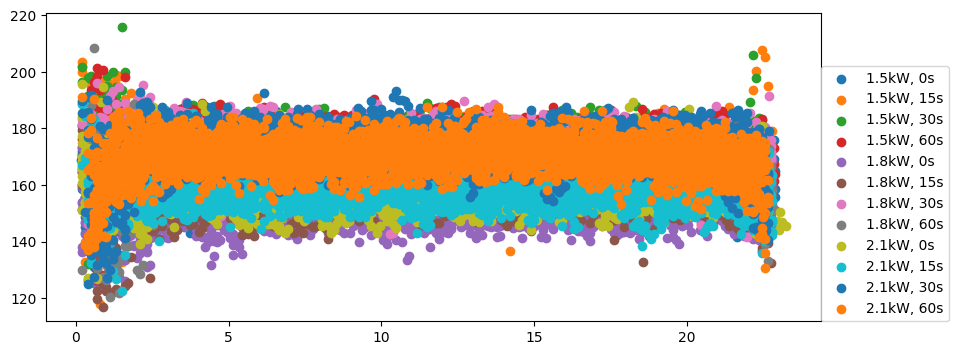

In [375]:
ac = cv.loc[cv.dataItemId=='Arc Current']
ac = buildNo(ac)
fig = plt.figure(figsize=(10,4))
for no in ac.buildNo.unique():
    data = ac.loc[ac.buildNo==no].reset_index()
    lab = data.loc[0, ['Power Setpoint (kW)', 'Dwell Time (s)']]
    power, dwell = lab[0], lab[1]
    plt.scatter(data['beadTime (s)'], data.MovAvgValue, label=f'{power}kW, {dwell}s')
plt.legend(loc=(1,0))

# Statistical Extraction

In [154]:
def extraction(grouped, valuename=None):
    # Extract statistical values for the parts of interest. 
    calc = ['Value', 'MovAvgValue']
    gc = grouped[calc]
    stats = {'mean': gc.mean(),
#             'count': gc.count(),
             'skew': gc.skew(),
             'std': gc.std(),
             'kurt': gc.apply(pd.DataFrame.kurt),
             }
    
    keys = list(stats.keys())
    for key in keys:
        stats[key].columns = [f'{key}_' + str(col) for col in stats[key].columns]
    
    joined = stats[keys[0]].join([stats[key] for key in keys[1:]])
    if valuename is not None:
        joined.columns =  [col.replace('Value',valuename) for col in joined.columns]        
    return joined

def buildNo(df):
    # 
    df = df.reset_index(drop=True)
    # Find where BeadNumber goes from 20 to 1. 
    idx = df.index[df['BeadNumber'].diff()==-19]  # Modify based off of layers 
    df['buildNo'] = 11 # 11 is the last build 
    start = 0 # initial build no. 
    for no, i  in enumerate(idx): 
        end = i
        df.loc[start:end, 'buildNo'] = no
        start=end
    return df

## Current / Voltage

In [6]:
def preprocess(df, name=None, drop=None, group=None):
    if name is not None:
        sub = df.loc[df['dataItemId']=='Arc Current']
    else:
        sub = df
    #sub = buildNo(sub)
    if drop is not None:
        av_cv = cv.drop(columns=drop, errors='ignore')
    if group is not None:
        sub = sub.groupby(by=group)
        return extraction(sub) # statistical extract
    else: 
        # sub.groupby('buildNo').count() # validate group sizes are correct
        return sub

gp = ['Power Setpoint (kW)', 'Dwell Time (s)', 'BeadNumber']
arcrm =  ['Traverse Speed (mm/s)', 'buildTime (s)', 'beadTime (s)',
          'dateTime', 'TimeDiff', 'beadPosition (mm)']

av_stat = preprocess(cv, name="Arc Voltage", drop=arcrm, group=gp)
ac_stat = preprocess(cv, name="Arc Current", drop=arcrm, group=gp)
ctwd_stat = preprocess(ctwd, drop= arcrm+['dataItemId','ReferenceValue'], group=gp)

## Merge dataframes

In [152]:
def rename_values(df, val):
    df.columns = [x.replace("Value", val) for x in df.columns]
    return df

arcCurrent = rename_values(ac_stat, "Current")
arcVoltage = rename_values(av_stat, "Voltage")
contactTipWD = rename_values(ctwd_stat, "CTWD")

merged_stats = arcCurrent.join([arcVoltage, contactTipWD])
merged_stats.to_csv('merged_beadnumber.csv')

In [83]:
cvg = cv.drop(columns=remove, errors='ignore')
cvg = cvg.groupby('dataItemId')
aC, aV = cvg.get_group("Arc Current"), cvg.get_group("Arc Voltage")
aC = aC.drop(columns=['dataItemId'], errors='ignore')
aV = aV.drop(columns=['dataItemId'],  errors='ignore')

# Packeting

In [570]:
pktno = 4 # packets per bead
cols = ['Power Setpoint (kW)', 'Dwell Time (s)', 
        'BeadNumber', 'buildTime (s)']
both = cv.merge(ctwd, how='outer')
# Time for packet length is based on the cumulative info for all df
pktgroups = both.groupby(['Power Setpoint (kW)', 'Dwell Time (s)', 'BeadNumber'])
pktTime = (pktgroups['buildTime (s)'].max() - pktgroups['buildTime (s)'].min()) / pktno

pktTime is the time contained in a single packet. This is variable based on the length of the bead to ensure that each bead has an equal number of packets of similar length in time. 

In [587]:
# Define Variables 
datas = ['Arc Current', 'Arc Voltage', 'CTWD (mm)']
stats = ['mean', 'kurt', 'std', 'skew']
valuenames = ['Current', 'Voltage', 'CTWD']
idcols = ['Power Setpoint (kW)', 'Dwell Time (s)', 'BeadNumber']

# Combine datasets and group
grouped = both.set_index(['dataItemId']+idcols, append=True)

# initialize empty frame
statframe = pd.DataFrame()
idxslice = pd.IndexSlice 

# Iterate through all value pairs of Power/Dwell/BeadNumber
jointype = 'outer'
mergeon = idcols+['Packet']

for idx in pktTime.index[0:3]:  # Per bead
    groupstats = pd.DataFrame(columns=idcols+ ['Packet']) 
    pktlength = pktTime[idx] # Determine packet time length 
    # Create groups based on time intervals
    group = grouped.loc[idxslice[:, :, idx[0], idx[1], idx[2]]]
    bins=[i * pktlength for i in range(0, int(group['beadTime (s)'].max() // pktlength + 1))]
    group['Packet']=pd.cut(group['beadTime (s)'],bins=bins,labels=False,right=False)+1
    pkg = group.groupby('Packet')
    for data, vn in zip(datas, valuenames):
        # Extract stats from packet groups
        pktstats = extraction(pkg, valuename=vn).reset_index()
        # Rejoin with other data types
        pktstats[idcols] = idx
        pktstats = pktstats.reset_index(drop=True)
        groupstats = groupstats.merge(pktstats, on=mergeon, how=jointype)
    # Calculate Power and Linear Energy Density 
    
    statframe = pd.concat([statframe,groupstats], axis=0)
    #jointype='inner' # after initial iteration, all cols are established 
    
statframe


(1.5, 0, 1)
(1.5, 0, 2)
(1.5, 0, 3)


,Packet,mean_Current,mean_MovAvgCurrent,skew_Current,skew_MovAvgCurrent,std_Current,std_MovAvgCurrent,kurt_Current,kurt_MovAvgCurrent,Power Setpoint (kW),...,kurt_Voltage,kurt_MovAvgVoltage,mean_CTWD,mean_MovAvgCTWD,skew_CTWD,skew_MovAvgCTWD,std_CTWD,std_MovAvgCTWD,kurt_CTWD,kurt_MovAvgCTWD
0,1.0,76.957761,76.732886,0.451647,0.392035,82.352992,81.284428,-1.725236,-1.851573,1.5,...,-1.725236,-1.851573,76.957761,76.732886,0.451647,0.392035,82.352992,81.284428,-1.725236,-1.851573
1,2.0,74.768506,74.794040,0.481498,0.429700,81.196392,80.551497,-1.695758,-1.817644,1.5,...,-1.695758,-1.817644,74.768506,74.794040,0.481498,0.429700,81.196392,80.551497,-1.695758,-1.817644
2,3.0,73.997636,74.133202,0.501134,0.430077,80.446236,79.667599,-1.654100,-1.816140,1.5,...,-1.654100,-1.816140,73.997636,74.133202,0.501134,0.430077,80.446236,79.667599,-1.654100,-1.816140
3,4.0,76.076568,76.121833,0.460504,0.398698,81.616457,80.820258,-1.706070,-1.844791,1.5,...,-1.706070,-1.844791,76.076568,76.121833,0.460504,0.398698,81.616457,80.820258,-1.706070,-1.844791
0,1.0,73.458492,72.635608,0.534021,0.441230,78.809557,76.654758,-1.566317,-1.784243,1.5,...,-1.566317,-1.784243,73.458492,72.635608,0.534021,0.441230,78.809557,76.654758,-1.566317,-1.784243
1,2.0,76.354940,76.274027,0.500794,0.390485,81.607250,80.031310,-1.598536,-1.845318,1.5,...,-1.598536,-1.845318,76.354940,76.274027,0.500794,0.390485,81.607250,80.031310,-1.598536,-1.845318
2,3.0,75.360108,75.367373,0.462752,0.394260,79.991203,79.071061,-1.699246,-1.843761,1.5,...,-1.699246,-1.843761,75.360108,75.367373,0.462752,0.394260,79.991203,79.071061,-1.699246,-1.843761
3,4.0,74.924315,74.984578,0.460969,0.395635,79.195468,78.378262,-1.687609,-1.830786,1.5,...,-1.687609,-1.830786,74.924315,74.984578,0.460969,0.395635,79.195468,78.378262,-1.687609,-1.830786
0,1.0,76.264941,76.317127,0.481321,0.449983,82.849792,82.570404,-1.720833,-1.795669,1.5,...,-1.720833,-1.795669,76.264941,76.317127,0.481321,0.449983,82.849792,82.570404,-1.720833,-1.795669
1,2.0,76.478586,76.592149,0.464374,0.414394,82.156993,81.608575,-1.720771,-1.829093,1.5,...,-1.720771,-1.829093,76.478586,76.592149,0.464374,0.414394,82.156993,81.608575,-1.720771,-1.829093


In [ ]:
    # Calculate Power and Linear Energy Density 
    #pkg_spans = pkg.max() - pkg.min()
    #beadstats['timeSpan'] = pkg_spans['buildTime (s)'].reset_index(drop=True)
    #beadstats['Position'] = pkg_spans['beadPosition (mm)'].reset_index(drop=True)


# Save files
## Save Packeted Values

In [252]:
pkt = 10 #
test, tbn = packetize_and_analyze(aC,10)#.to_csv(f'arcCurrent_pkt{pkt}.csv')
tbn

Packet  Power Setpoint (kW)  Dwell Time (s)
1       1.5                  0                 218
                             15                 42
2       1.5                  15                177
                             30                 83
3       1.5                  30                135
                                              ... 
198     2.1                  15                140
199     2.1                  15                 82
                             30                182
200     2.1                  30                 36
                             60                222
Name: BeadNumber, Length: 419, dtype: int64

# Plotting

KeyError: 'std_MovAvgCurrent'

<Figure size 1000x600 with 0 Axes>

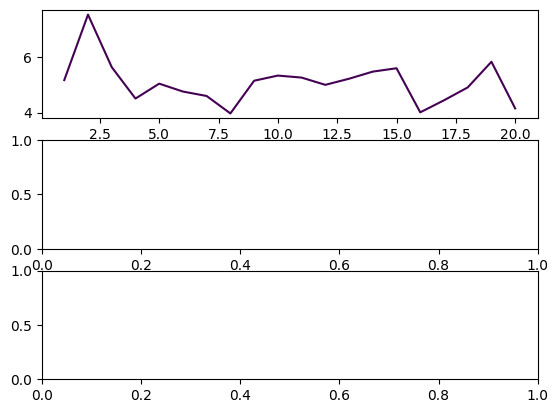

In [168]:
import numpy as np
import matplotlib.lines as mlines

powers = cv['Power Setpoint (kW)'].unique()
dwell_times = cv['Dwell Time (s)'].unique()
graphby = 'std_MovAvgCurrent'
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(powers)))
lss = ['solid', 'dotted', 'dashed', 'dashdot']
color_lines = []
ls_lines = []
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
for ddx, dT in enumerate(dwell_times):    
    for idx, power in enumerate(powers):
        aC = arcCurrent.loc[(power, dT, slice(None)), :].reset_index()
        aV = arcVoltage.loc[(power, dT, slice(None)), :].reset_index()
        CTWD = contactTipWD.loc[(power, dT, slice(None)), :].reset_index()
        ax1.plot(aC['BeadNumber'], aC[graphby], color=colors[idx], linestyle=lss[ddx])
        ax2.plot(aV['BeadNumber'], aV[graphby], color=colors[idx], linestyle=lss[ddx])
        ax3.plot(CTWD['BeadNumber'], CTWD[graphby], color=colors[idx], linestyle=lss[ddx])

        if ddx == 0:
            color_lines.append(mlines.Line2D([], [], color=colors[idx], label=f'{power} kW'))
        if idx == 0:
            ls_lines.append(mlines.Line2D([], [], color='black', linestyle=lss[ddx], label=f'{dT} sec.'))

# Add the legends to one of the axes (or all of them if desired)
ax1.legend(handles=color_lines, bbox_to_anchor=(1, 1), title='Power')
ax2.legend(handles=ls_lines, bbox_to_anchor=(1, 1), title='Dwell Time')

fig.suptitle(graphby)
ax1.set_xticks([]), ax2.set_xticks([])
plt.xlabel('BeadNumber')
plt.xticks(np.arange(1,21))
ax1.set_ylabel('Arc Current (A)'), ax2.set_ylabel('Arc Voltage (V)')
ax3.set_ylabel('CTWD')
plt.tight_layout()
plt.savefig(f'{graphby}.png', dpi=300)
